# Derive a new detector slice mask

In this notebook we use the procedure delineated in notebook 1 and notebook 2, to create the final slice maps. For each spectral band, nine slice maps are created, corresponding to nine transmission criteria (10%, 20%, ..., 80%, and 90%).

In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

An example figure is shown here as a check of the code functioning.

In [1]:
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# load objects
sliceMap_0percent   = funcs.load_obj('sliceMap_0percent')
sliceEdges_0percent = funcs.load_obj('sliceEdges_0percent')

# initialize placeholders
transm_img,new_sliceMap,new_sliceMap_poly = {},{},{}

In [4]:
# Define the ids of the individual slices
sliceid1=[111,121,110,120,109,119,108,118,107,117,106,116,105,115,104,114,103,113,102,112,101]
sliceid2=[201,210,202,211,203,212,204,213,205,214,206,215,207,216,208,217,209]
sliceid3=[316,308,315,307,314,306,313,305,312,304,311,303,310,302,309,301]
sliceid4=[412,406,411,405,410,404,409,403,408,402,407,401]

In [5]:
sliceMap,alphaMap,sci_signal,sci_signal_error = {},{},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']: 
    # Load slice mask extension of distortion map
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band] = d2cMaps['sliceMap']
    alphaMap[band] = d2cMaps['alphaMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    fringe_img_error = funcs.get_cdps(band,cdpDir,output='img_error')[0]
    fringe_img_error[np.isnan(fringe_img_error)] = 0.05
    
    # Load external extended source signal
    if band == '4C':
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
        source_signal_error,bkg_signal_error = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img_error')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
        
        sci_signal_subtrbkg_error  = np.sqrt(source_signal_error**2 + bkg_signal_error**2)
        sci_signal_divfringe_error = np.abs(sci_signal[band]) * np.sqrt((sci_signal_subtrbkg_error / (source_signal-bkg_signal))**2 + (fringe_img_error/fringe_img)**2 )
        sci_signal_error[band] = sci_signal_divfringe_error
    else:
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
        source_signal_error,bkg_signal_error = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img_error')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
        
        sci_signal_subtrbkg_error  = np.sqrt(source_signal_error**2 + bkg_signal_error**2)
        sci_signal_divfringe_error = np.abs(sci_signal[band]) * np.sqrt((sci_signal_subtrbkg_error / (source_signal-bkg_signal))**2 + (fringe_img_error/fringe_img)**2 )
        sci_signal_error[band] = sci_signal_divfringe_error

In [6]:
transm_criteria = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [ ]:
for transm_criterion in transm_criteria:
    print 'Transmission {}'.format(transm_criterion)
    transm_img[str(transm_criterion)],new_sliceMap[str(transm_criterion)],new_sliceMap_poly[str(transm_criterion)] = {},{},{}
    for band in ['1A']:
        print 'Band {}'.format(band)
        if band[0] in ['1','2']: margin = 5 # pixels
        elif band[0] in ['3','4']: margin = 7 # pixels
        transm_img[str(transm_criterion)][band],new_sliceMap[str(transm_criterion)][band],new_sliceMap_poly[str(transm_criterion)][band] = funcs.slice_mapping(band,sci_signal[band],sci_signal_error[band],sliceMap_0percent[band],margin=margin,stop_criterion=5.,transm_criterion=transm_criterion)

<IPython.core.display.Javascript object>


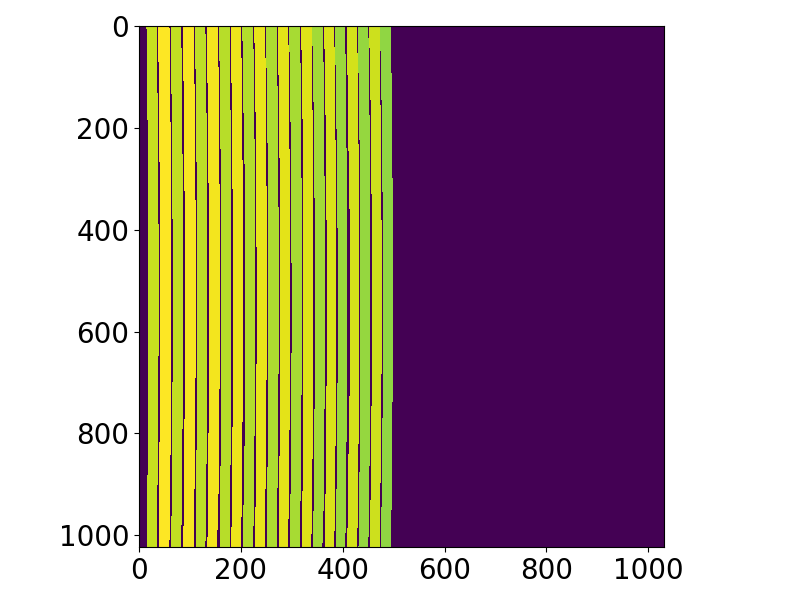

<IPython.core.display.Javascript object>


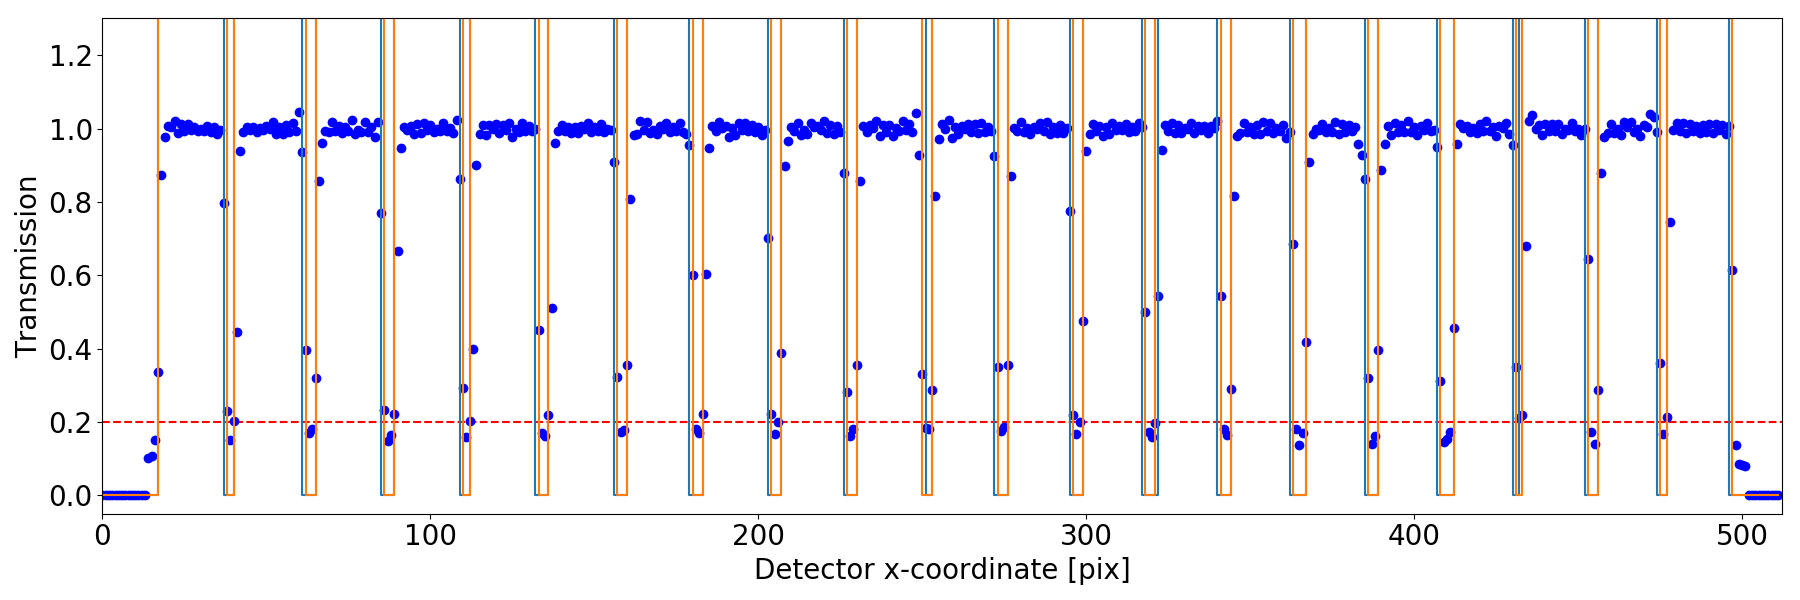

In [13]:
band = '1A'
transm_criterion = 0.2

# plt.figure(figsize=(8,6))
# plt.imshow(new_sliceMap[str(transm_criterion)][band])
# plt.tight_layout()

plt.figure(figsize=(8,6))
plt.imshow(new_sliceMap_poly[str(transm_criterion)][band])
plt.tight_layout()

row = 512
if band[0] in ['1','4']:
    plt.figure(figsize=(18,6))
    plt.plot(np.arange(len(transm_img[str(transm_criterion)][band][row,:512])),transm_img[str(transm_criterion)][band][row,:512],'bo')
    plt.step(np.arange(len(new_sliceMap[str(transm_criterion)][band][row,:512])),new_sliceMap[str(transm_criterion)][band][row,:512])
    plt.step(np.arange(len(new_sliceMap_poly[str(transm_criterion)][band][row,:512])),new_sliceMap_poly[str(transm_criterion)][band][row,:512])
    plt.hlines(transm_criterion,0,512,'r',linestyle='dashed')
    plt.ylim(-0.05,1.3)
    plt.xlim(0,512)
    plt.xlabel('Detector x-coordinate [pix]')
    plt.ylabel('Transmission')
    plt.tight_layout()
elif band[0] in ['2','3']:
    plt.figure(figsize=(18,6))
    plt.plot(np.arange(len(transm_img[str(transm_criterion)][band][row,512:])),transm_img[str(transm_criterion)][band][row,512:],'bo')
    plt.step(np.arange(len(new_sliceMap[str(transm_criterion)][band][row,512:])),new_sliceMap[str(transm_criterion)][band][row,512:])
    plt.step(np.arange(len(new_sliceMap_poly[str(transm_criterion)][band][row,512:])),new_sliceMap_poly[str(transm_criterion)][band][row,512:])
    plt.hlines(transm_criterion,0,512,'r',linestyle='dashed')
    plt.ylim(-0.05,1.3)
    plt.xlim(0,512)
    plt.xlabel('Detector x-coordinate [pix]')
    plt.ylabel('Transmission')
    plt.tight_layout()

In [10]:
# save responses to CDP
outDir = cdpDir+"CDP7/"

def makeHeader(detector, channel, band):
    hdu0 = fits.PrimaryHDU()
    hdu0.header["TELESCOP"]="JWST"
    hdu0.header["INSTRUME"]="MIRI"
    hdu0.header["MODELNAM"]=("FM", "Instrument model name")
    hdu0.header["DETECTOR"]=detector
    hdu0.header["DETSETNG"]="ANY"
    hdu0.header["READPATT"]="ANY"
    hdu0.header["SUBARRAY"]="GENERIC"
    hdu0.header["SUBSTRT1"]= 1                                            
    hdu0.header["SUBSIZE1"]= 1032                                              
    hdu0.header["SUBSTRT2"]= 1                                                
    hdu0.header["SUBSIZE2"]= 1024                                           
    hdu0.header["FASTAXIS"]= 1                                               
    hdu0.header["SLOWAXIS"]= 2
    hdu0.header["CHANNEL"] = channel
    hdu0.header["BAND"]    = band
    hdu0.header["FILENAME"]= "MIRI_FM_"+detector+"_"+channel+band+"_SLICEMAP_7B.00.00.fits"
    hdu0.header["DATE"]="2018-07-05"
    hdu0.header["VERSION"] ="7B.00.00"
    hdu0.header["USEAFTER"] ="2000-01-01T00:00:00"
    hdu0.header["AUTHOR"]  ="Ioannis Argyriou and Bart Vandenbussche"
    hdu0.header["COAUTHOR"]  ="Adrian Glauser and Polychronis Patapis"
    hdu0.header["ORIGIN"]  = "MIRI European Consortium"
    hdu0.header["EXP_TYPE"]= "MIR_MRS"
    hdu0.header["REFTYPE"] ="SLICEMAP"
    hdu0.header["DESCRIP"] = 'CDP-7 MIRI MRS detector slice map'
    hdu0.header["PEDIGREE"] = 'GROUND'
    hdu0.header.add_history("DOCUMENT: MIRI-TN-00005-KUL Issue 1.0")
    hdu0.header.add_history("SOFTWARE: MIRICLE ")
    hdu0.header.add_history("DATA USED: RAL FM data obsId 12688")
    return hdu0

# Band 1A/2A

In [26]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'SHORT'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['1A']+new_sliceMap_poly['0.1']['2A']
sliceMap_20percent = new_sliceMap_poly['0.2']['1A']+new_sliceMap_poly['0.2']['2A']
sliceMap_30percent = new_sliceMap_poly['0.3']['1A']+new_sliceMap_poly['0.3']['2A']
sliceMap_40percent = new_sliceMap_poly['0.4']['1A']+new_sliceMap_poly['0.4']['2A']
sliceMap_50percent = new_sliceMap_poly['0.5']['1A']+new_sliceMap_poly['0.5']['2A']
sliceMap_60percent = new_sliceMap_poly['0.6']['1A']+new_sliceMap_poly['0.6']['2A']
sliceMap_70percent = new_sliceMap_poly['0.7']['1A']+new_sliceMap_poly['0.7']['2A']
sliceMap_80percent = new_sliceMap_poly['0.8']['1A']+new_sliceMap_poly['0.8']['2A']
sliceMap_90percent = new_sliceMap_poly['0.9']['1A']+new_sliceMap_poly['0.9']['2A']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)

# Band 1B/2B

In [31]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'MEDIUM'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['1B']+new_sliceMap_poly['0.1']['2B']
sliceMap_20percent = new_sliceMap_poly['0.2']['1B']+new_sliceMap_poly['0.2']['2B']
sliceMap_30percent = new_sliceMap_poly['0.3']['1B']+new_sliceMap_poly['0.3']['2B']
sliceMap_40percent = new_sliceMap_poly['0.4']['1B']+new_sliceMap_poly['0.4']['2B']
sliceMap_50percent = new_sliceMap_poly['0.5']['1B']+new_sliceMap_poly['0.5']['2B']
sliceMap_60percent = new_sliceMap_poly['0.6']['1B']+new_sliceMap_poly['0.6']['2B']
sliceMap_70percent = new_sliceMap_poly['0.7']['1B']+new_sliceMap_poly['0.7']['2B']
sliceMap_80percent = new_sliceMap_poly['0.8']['1B']+new_sliceMap_poly['0.8']['2B']
sliceMap_90percent = new_sliceMap_poly['0.9']['1B']+new_sliceMap_poly['0.9']['2B']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)

# Band 1C/2C

In [33]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'LONG'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['1C']+new_sliceMap_poly['0.1']['2C']
sliceMap_20percent = new_sliceMap_poly['0.2']['1C']+new_sliceMap_poly['0.2']['2C']
sliceMap_30percent = new_sliceMap_poly['0.3']['1C']+new_sliceMap_poly['0.3']['2C']
sliceMap_40percent = new_sliceMap_poly['0.4']['1C']+new_sliceMap_poly['0.4']['2C']
sliceMap_50percent = new_sliceMap_poly['0.5']['1C']+new_sliceMap_poly['0.5']['2C']
sliceMap_60percent = new_sliceMap_poly['0.6']['1C']+new_sliceMap_poly['0.6']['2C']
sliceMap_70percent = new_sliceMap_poly['0.7']['1C']+new_sliceMap_poly['0.7']['2C']
sliceMap_80percent = new_sliceMap_poly['0.8']['1C']+new_sliceMap_poly['0.8']['2C']
sliceMap_90percent = new_sliceMap_poly['0.9']['1C']+new_sliceMap_poly['0.9']['2C']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)

# Band 3A/4A

In [10]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'SHORT'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['3A']+new_sliceMap_poly['0.1']['4A']
sliceMap_20percent = new_sliceMap_poly['0.2']['3A']+new_sliceMap_poly['0.2']['4A']
sliceMap_30percent = new_sliceMap_poly['0.3']['3A']+new_sliceMap_poly['0.3']['4A']
sliceMap_40percent = new_sliceMap_poly['0.4']['3A']+new_sliceMap_poly['0.4']['4A']
sliceMap_50percent = new_sliceMap_poly['0.5']['3A']+new_sliceMap_poly['0.5']['4A']
sliceMap_60percent = new_sliceMap_poly['0.6']['3A']+new_sliceMap_poly['0.6']['4A']
sliceMap_70percent = new_sliceMap_poly['0.7']['3A']+new_sliceMap_poly['0.7']['4A']
sliceMap_80percent = new_sliceMap_poly['0.8']['3A']+new_sliceMap_poly['0.8']['4A']
sliceMap_90percent = new_sliceMap_poly['0.9']['3A']+new_sliceMap_poly['0.9']['4A']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)

# Band 3B/4B

In [15]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'MEDIUM'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['3B']+new_sliceMap_poly['0.1']['4B']
sliceMap_20percent = new_sliceMap_poly['0.2']['3B']+new_sliceMap_poly['0.2']['4B']
sliceMap_30percent = new_sliceMap_poly['0.3']['3B']+new_sliceMap_poly['0.3']['4B']
sliceMap_40percent = new_sliceMap_poly['0.4']['3B']+new_sliceMap_poly['0.4']['4B']
sliceMap_50percent = new_sliceMap_poly['0.5']['3B']+new_sliceMap_poly['0.5']['4B']
sliceMap_60percent = new_sliceMap_poly['0.6']['3B']+new_sliceMap_poly['0.6']['4B']
sliceMap_70percent = new_sliceMap_poly['0.7']['3B']+new_sliceMap_poly['0.7']['4B']
sliceMap_80percent = new_sliceMap_poly['0.8']['3B']+new_sliceMap_poly['0.8']['4B']
sliceMap_90percent = new_sliceMap_poly['0.9']['3B']+new_sliceMap_poly['0.9']['4B']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)

# Band 3C/4C

In [11]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
band = 'LONG'
hdu0 = makeHeader(detector, channel, band)

sliceMap_10percent = new_sliceMap_poly['0.1']['3C']+new_sliceMap_poly['0.1']['4C']
sliceMap_20percent = new_sliceMap_poly['0.2']['3C']+new_sliceMap_poly['0.2']['4C']
sliceMap_30percent = new_sliceMap_poly['0.3']['3C']+new_sliceMap_poly['0.3']['4C']
sliceMap_40percent = new_sliceMap_poly['0.4']['3C']+new_sliceMap_poly['0.4']['4C']
sliceMap_50percent = new_sliceMap_poly['0.5']['3C']+new_sliceMap_poly['0.5']['4C']
sliceMap_60percent = new_sliceMap_poly['0.6']['3C']+new_sliceMap_poly['0.6']['4C']
sliceMap_70percent = new_sliceMap_poly['0.7']['3C']+new_sliceMap_poly['0.7']['4C']
sliceMap_80percent = new_sliceMap_poly['0.8']['3C']+new_sliceMap_poly['0.8']['4C']
sliceMap_90percent = new_sliceMap_poly['0.9']['3C']+new_sliceMap_poly['0.9']['4C']

hdu1 = fits.ImageHDU(data=sliceMap_10percent, header=None, name="Slice_Map_10%")
hdu2 = fits.ImageHDU(data=sliceMap_20percent, header=None, name="Slice_Map_20%")
hdu3 = fits.ImageHDU(data=sliceMap_30percent, header=None, name="Slice_Map_30%")
hdu4 = fits.ImageHDU(data=sliceMap_40percent, header=None, name="Slice_Map_40%")
hdu5 = fits.ImageHDU(data=sliceMap_50percent, header=None, name="Slice_Map_50%")
hdu6 = fits.ImageHDU(data=sliceMap_60percent, header=None, name="Slice_Map_60%")
hdu7 = fits.ImageHDU(data=sliceMap_70percent, header=None, name="Slice_Map_70%")
hdu8 = fits.ImageHDU(data=sliceMap_80percent, header=None, name="Slice_Map_80%")
hdu9 = fits.ImageHDU(data=sliceMap_90percent, header=None, name="Slice_Map_90%")

hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3,hdu4,hdu5,hdu6,hdu7,hdu8,hdu9])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_SLICEMAP_7B.00.00.fits".format(detector,channel,band),overwrite=True)